# Introduction

- **Problem Statement:**
  - Stock exchanges experience heightened activity and volatility as they near the day's end, especially in the last ten minutes. These critical moments often witness rapid price changes and can significantly influence the day's global economic outlook. The closing price of a stock is often considered its most important price of the day. It's used as a reference point by investors, analysts, and financial media. Since it represents the final consensus of value for the stock on that particular day, many technical and fundamental analysis tools hinge on it.
  - In this project, I would like to utilize machine learning models to predict the closing price movements (indicated by a specifically defined synthetic index) for hundreds of Nasdaq listed stocks.

- **Problem Type:** It's a regression problem on time-series dataset.
  
- **Data Source:** The data is directly downloaded from Kaggle -- it's a competition dataset provided by Optiver.
  
- **Data Collection:** This dataset contains historic data for the daily ten minute closing auction on the NASDAQ stock exchange. The data is collected from the traditional order books and the closing auctions of the stocks by Optiver. The target variable is a synthetic index composed of NASDAQ-listed stocks, which indicates the closing price movement for each single stock. It's noted that the unique stocks and dates are replaced by id to avoid data leakage.

- **Importance:**
  - The prediction model can contribute to combine signals from the auction and the (non-auction) order book, which will help improve the market efficiency and accessibility, especially in the last ten minutes of trading. The ability to consolidate information from both sources is critical for providing the best prices to all market participants. Plus, information from the auction can be used to adjust prices, assess supply and demand dynamics, and identify trading opportunities.
  - The project provides firsthand experience in handling real-world data science problems, mirroring those encountered by traders, quantitative researchers, and engineers.

- **Encyclopedia:**
  - Nasdaq: The Nasdaq Stock Market is an American stock exchange based in New York City. It is the most active stock trading venue in the US by volume. Every trading day on the Nasdaq Stock Exchange ends with a special process called the "Nasdaq Closing Cross Auction." This is a mechanism that helps determine the final or official closing price for stocks listed on the Nasdaq.
  - Book: In the context of stock exchanges and trading systems, the term "book" often refers to an electronic record of all the buy and sell orders that are waiting to be executed. There are different types of books based on the nature of the order and the mechanism through which these orders get executed.
  - Auction Book: This contains orders that are executed through an auction mechanism. In auctions, buy and sell orders are aggregated, and a single price (the auction price) is determined where the maximum volume can be executed. Auctions are typically used at the opening and closing of markets, though some markets may have intraday auctions as well.
  - Non-Auction Book: This typically contains orders that are executed continuously during trading hours outside of the auction mechanisms. They are matched on a continuous basis as and when compatible buy and sell orders (in terms of price and other conditions) are entered. This is the usual method of trading in many markets during regular hours.
     
- **References:**
  - [Kaggle: Optiver - Trading at the Close](https://www.kaggle.com/competitions/optiver-trading-at-the-close/overview)
  - [Order Book](https://www.investopedia.com/terms/o/order-book.asp)
  - [Nasdaq Stock Market Rules](https://www.sec.gov/files/rules/sro/nasdaq/2017/34-81188-ex5.pdf)


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.width', 1000)

In [2]:
data = pd.read_csv('../data/raw_kaggle/train.csv')
display(data.head())

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.6900,1,0.9998,13380276.6400,NaN,NaN,0.9998,60651.5000,1.0000,8493.0300,1.0000,-3.0297,0,0_0_0
1,1,0,0,166603.9100,-1,0.9999,1642214.2500,NaN,NaN,0.9999,3233.0400,1.0007,20605.0900,1.0000,-5.5200,0,0_0_1
2,2,0,0,302879.8700,-1,0.9996,1819368.0300,NaN,NaN,0.9994,37956.0000,1.0003,18995.0000,1.0000,-8.3900,0,0_0_2
3,3,0,0,11917682.2700,-1,1.0002,18389745.6200,NaN,NaN,1.0000,2324.9000,1.0002,479032.4000,1.0000,-4.0102,0,0_0_3
4,4,0,0,447549.9600,-1,0.9995,17860614.9500,NaN,NaN,0.9994,16485.5400,1.0000,434.1000,1.0000,-7.3498,0,0_0_4


# General Data Description

- Data shape: there're 5237980 rows and 17 columns in the dataset.
  - 1 target variable: continuous
  - 5 Identifiers:
    - 3 major ones (also features): stock_id (0-199), date_id (0-481), seconds_in_bucket (9 min data: 0-540 for every 10 seconds),
    - 2 for splitting & submission: determined by the previous 3: time_id, row_id (row_id is the unique identifier)
  - 11 market features:
    - Auction book: imbalance_size, imbalance_buy_sell_flag, reference_price, matched_size, far_price,
    - Auction + non-auction book: near_price,
    - Non-auction book: bid_price, bid_size, ask_price, ask_size, wap
- Description (statistics) & Missing values for given data:
  - far_price and near_price: missing 50% data
  - imbalance_size, reference_price, matched_size, bid_price, ask_price, wap: missing 220 records (4 stocks one day)
  - target: missing 88 records (this may affect our train-test split, we will explore this feature later)
- Time Series Structure: ID information (stock_id, date_id, seconds_in_bucket, time_id, row_id)

- **Challenge:**
  - Non-iid time series data
  - Missing values in columns & time structure
  - Large dataset
  - Domain knowledge

In [3]:
# Data shape, missing count
print('data shape:', data.shape)
display(data.isnull().sum().to_frame().T)
display(data.isnull().mean().to_frame().sort_values(by=0, ascending=False).T)

data shape: (5237980, 17)


,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,220,0,220,220,2894342,2857180,220,0,220,0,220,88,0,0


,far_price,near_price,ask_price,imbalance_size,reference_price,matched_size,wap,bid_price,target,time_id,ask_size,stock_id,bid_size,date_id,imbalance_buy_sell_flag,seconds_in_bucket,row_id
0,0.5526,0.5455,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [76]:
# Statistics
description = data.describe()
display(description)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id
count,5237980.0000,5237980.0000,5237980.0000,5237760.0000,5237980.0000,5237760.0000,5237760.0000,2343638.0000,2380800.0000,5237760.0000,5237980.0000,5237760.0000,5237980.0000,5237760.0000,5237892.0000,5237980.0000
mean,99.2886,241.5100,270.0000,5715293.0987,-0.0119,1.0000,45100245.2844,1.0017,0.9997,0.9997,51813.5929,1.0003,53575.6833,1.0000,-0.0476,13310.0521
std,57.8718,138.5319,158.7451,20515906.2972,0.8853,0.0025,139841291.2774,0.7215,0.0122,0.0025,111421.4055,0.0025,129355.4357,0.0025,9.4529,7619.2710
min,0.0000,0.0000,0.0000,0.0000,-1.0000,0.9353,4316.6100,0.0001,0.7870,0.9349,0.0000,0.9398,0.0000,0.9380,-385.2898,0.0000
25%,49.0000,122.0000,130.0000,84534.1500,-1.0000,0.9988,5279575.1650,0.9963,0.9971,0.9985,7374.7200,0.9990,7823.7000,0.9988,-4.5598,6729.0000
50%,99.0000,242.0000,270.0000,1113604.4400,0.0000,1.0000,12882638.5600,0.9999,0.9999,0.9997,21969.0000,1.0002,23017.9200,1.0000,-0.0602,13345.0000
75%,149.0000,361.0000,410.0000,4190951.0025,1.0000,1.0012,32700130.5800,1.0033,1.0026,1.0009,55831.6800,1.0014,57878.4100,1.0011,4.4096,19907.0000
max,199.0000,480.0000,540.0000,2982027811.6800,1.0000,1.0775,7713682054.0500,437.9531,1.3097,1.0775,30287840.0000,1.0778,54405000.0000,1.0777,446.0704,26454.0000


## Time Series Structure: 

ID information (stock_id, date_id, seconds_in_bucket, time_id, row_id) gives unique identifier for stock and time
- time_id can be constructed using (date_id, seconds_in_bucket)
- row_id can be constructed using (date_id, seconds_in_bucket, stock_id). Data is originally sorted by row_id.

The data should be split by date: there will be 200  ∗ 481  ∗ 55 records if no missing dates for each stock

### stock_id (Categorical data)
A unique identifier for the stock. Not all stock IDs exist in every time bucket (date, time_id).

We see that there are in total 200 stocks, with 11 of them missing values in some time buckets.

In [5]:
print('Stock number:', data.stock_id.nunique())

display(data.stock_id.value_counts().to_frame().sort_values(by='count').T)
count_stock = data.stock_id.value_counts()
print('Stock missing values:', len(count_stock[count_stock!=26455]))

Stock number: 200


stock_id,102,135,79,199,153,150,156,69,78,73,99,13,12,11,7,9,8,14,10,15,19,17,18,6,20,21,22,23,48,16,5,27,25,31,32,33,34,35,36,38,49,39,40,41,42,43,98,45,46,47,50,26,24,3,81,76,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,70,71,4,52,87,72,74,77,80,30,83,84,85,86,88,51,89,90,91,92,93,94,95,96,97,75,2,82,0,37,103,1,105,106,107,108,109,110,111,113,123,114,115,116,117,118,119,120,121,122,148,112,151,149,126,137,127,128,129,130,131,132,133,134,136,138,125,139,140,141,142,143,144,145,146,147,124,28,100,179,157,158,159,160,161,162,163,165,175,166,167,168,169,170,171,172,173,174,101,104,44,155,188,154,152,180,181,182,183,184,185,186,187,189,177,190,191,192,193,194,195,196,197,198,178,176,164,29
count,10230,15950,16500,21615,22605,23210,24420,24420,26235,26400,26400,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455,26455


Stock missing values: 11


### date_id
A unique identifier for the date. Date IDs are sequential & consistent across all stocks.

In [6]:
print('date count:', data.date_id.nunique())

display(data.date_id.value_counts().to_frame().sort_values(by='count').T)
count_stock = data.date_id.value_counts()

date count: 481


date_id,0,2,3,1,4,6,7,5,9,10,11,8,13,14,15,17,12,18,20,19,16,21,33,24,25,23,27,28,29,26,31,32,34,35,36,30,22,44,43,41,38,39,37,48,45,40,46,57,42,49,54,50,58,55,56,53,52,51,47,61,64,60,62,59,69,65,67,68,63,66,79,71,72,73,74,75,76,77,70,87,78,86,85,84,138,82,81,80,83,96,94,88,89,90,91,92,93,134,107,95,...,385,386,367,366,379,319,390,361,392,393,394,395,396,397,398,412,399,402,403,404,405,406,407,408,409,410,400,391,433,411,401,421,415,416,417,418,419,420,426,423,434,424,427,428,429,430,431,414,432,422,413,425,387,460,461,440,441,442,443,444,445,435,446,448,449,450,451,452,453,454,455,456,447,389,439,438,437,457,462,463,464,465,466,467,468,469,470,436,471,473,474,475,476,477,478,479,459,458,472,480
count,10505,10505,10505,10505,10560,10560,10560,10560,10560,10560,10560,10560,10560,10560,10560,10560,10560,10560,10560,10560,10560,10560,10560,10560,10560,10560,10560,10560,10560,10560,10560,10560,10560,10560,10560,10560,10560,10670,10670,10670,10670,10670,10670,10670,10670,10670,10670,10670,10670,10670,10670,10670,10670,10670,10670,10670,10670,10670,10670,10725,10725,10725,10725,10725,10725,10725,10725,10725,10725,10725,10780,10780,10780,10780,10780,10780,10780,10780,10780,10780,10780,10780,10780,10780,10780,10780,10780,10780,10780,10835,10835,10835,10835,10835,10835,10835,10835,10835,10835,10835,...,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000,11000


### seconds_in_bucket
The number of seconds elapsed since the beginning of the day's closing auction, always starting from 0. (9min=540s --> 55 counts for every 10s of data)

time_id is additionally given in training set: time_id = 481 ∗ 55 (Number of date * Number of seconds in bucket in a d

- We see not all time bucket contains all the stocksay)

In [7]:
print('second count:', data.seconds_in_bucket.nunique())

display(data.seconds_in_bucket.value_counts().to_frame().sort_values(by='count').T)
count_stock = data.seconds_in_bucket.value_counts()
# No missing because if a stock have data for a date, we will have the whole 9min data
print('data every 10 seconds', 5237980/55)

second count: 55


seconds_in_bucket,0,130,20,30,40,50,60,70,80,90,100,110,10,120,260,150,160,170,180,190,200,210,220,230,240,140,250,270,530,410,300,310,320,330,340,350,360,370,380,390,290,400,280,430,440,450,460,470,480,490,500,510,520,420,540
count,95236,95236,95236,95236,95236,95236,95236,95236,95236,95236,95236,95236,95236,95236,95236,95236,95236,95236,95236,95236,95236,95236,95236,95236,95236,95236,95236,95236,95236,95236,95236,95236,95236,95236,95236,95236,95236,95236,95236,95236,95236,95236,95236,95236,95236,95236,95236,95236,95236,95236,95236,95236,95236,95236,95236


data every 10 seconds 95236.0


In [8]:
print('time_id count:', data.time_id.nunique())
display(data.time_id.value_counts().to_frame().sort_values(by='count').T)
count_stock = data.time_id.value_counts()
print('time bucket (date-seconds) with missing stocks:', len(count_stock[count_stock!=200]))
print('Unique count of stocks for all time_id:', count_stock.unique())
print('time_id count:', 481*55)

time_id count: 26455


time_id,0,3,4,5,6,7,8,9,10,11,53,12,14,15,16,17,18,19,20,21,22,23,24,13,2,110,25,26,31,32,33,34,35,36,37,38,39,40,41,54,42,44,45,46,47,48,49,50,51,52,29,27,43,28,56,85,59,60,61,62,63,82,65,66,67,68,69,58,64,72,73,74,75,76,77,78,79,80,81,70,71,30,57,83,86,87,88,89,90,91,92,93,94,95,84,108,96,99,100,101,...,26339,26357,26361,26362,26363,26364,26365,26358,26366,26355,26368,26370,26371,26372,26373,26374,26367,26337,26369,21366,26319,26376,26381,26382,26383,26384,26385,26414,26386,26380,26388,26390,26391,26392,26393,26394,26387,26415,26389,26416,26379,26396,26400,26401,26402,26403,26404,26405,26406,26395,26407,26409,26410,26411,26412,26413,26398,26397,26408,26375,26417,26439,26420,26421,26422,26423,26424,26435,26425,26419,26427,26429,26430,26431,26432,26433,26426,26377,26428,26438,26418,26436,26440,26441,26442,26443,26444,26437,26445,26434,26447,26449,26450,26451,26452,26453,26446,26378,26448,26454
count,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,191,...,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200


time bucket (date-seconds) with missing stocks: 16280
Unique count of stocks for all time_id: [200 199 198 197 196 195 194 192 191]
time_id count: 26455


### Construct Structured Time Series DataFrame: check missing records in time

- We see there are 11 stocks not covering all dates (stock_id: 102, 135, 79, 199, 153, 150, 69, 156, 78, 99, 73)
- If a date is missing, all the 9-min data (55 records each, 540 seconds) will be missing
- Except stock 73 (missing on date 320) and 99 (missing on date 138), which only have 1 missing records, all the other stock has continuous missing dates starting from date zero.

In [9]:
keys = ['stock_id', 'date_id', 'seconds_in_bucket', 'time_id']
stock_list = data[['stock_id']].drop_duplicates().sort_values(by='stock_id').reset_index(drop=True)
date_list =  data[['date_id']].drop_duplicates().sort_values(by='date_id').reset_index(drop=True)
seconds_list = data[['seconds_in_bucket']].drop_duplicates().sort_values(by='seconds_in_bucket').reset_index(drop=True)

time_list = pd.merge(date_list, seconds_list, how='cross')
time_list['time_id'] = time_list.index

expanded_data = time_list.merge(stock_list, how='cross')
expanded_data = expanded_data[keys]
expanded_data = expanded_data.merge(data, on=keys, how='left')
display(expanded_data)

,stock_id,date_id,seconds_in_bucket,time_id,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,row_id
0,0,0,0,0,3180602.6900,1.0000,0.9998,13380276.6400,NaN,NaN,0.9998,60651.5000,1.0000,8493.0300,1.0000,-3.0297,0_0_0
1,1,0,0,0,166603.9100,-1.0000,0.9999,1642214.2500,NaN,NaN,0.9999,3233.0400,1.0007,20605.0900,1.0000,-5.5200,0_0_1
2,2,0,0,0,302879.8700,-1.0000,0.9996,1819368.0300,NaN,NaN,0.9994,37956.0000,1.0003,18995.0000,1.0000,-8.3900,0_0_2
3,3,0,0,0,11917682.2700,-1.0000,1.0002,18389745.6200,NaN,NaN,1.0000,2324.9000,1.0002,479032.4000,1.0000,-4.0102,0_0_3
4,4,0,0,0,447549.9600,-1.0000,0.9995,17860614.9500,NaN,NaN,0.9994,16485.5400,1.0000,434.1000,1.0000,-7.3498,0_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5290995,195,480,540,26454,2440722.8900,-1.0000,1.0003,28280361.7400,0.9997,0.9997,1.0003,32257.0400,1.0004,319862.4000,1.0003,2.3103,480_540_195
5290996,196,480,540,26454,349510.4700,-1.0000,1.0006,9187699.1100,1.0001,1.0004,1.0006,205108.4000,1.0009,93393.0700,1.0008,-8.2201,480_540_196
5290997,197,480,540,26454,0.0000,0.0000,0.9958,12725436.1000,0.9958,0.9958,0.9958,16790.6600,0.9959,180038.3200,0.9958,1.1694,480_540_197
5290998,198,480,540,26454,1000898.8400,1.0000,0.9992,94773271.0500,0.9992,0.9992,0.9990,125631.7200,0.9992,669893.0000,0.9990,-1.5402,480_540_198


In [10]:
display(expanded_data.isnull().sum().to_frame().T)

,stock_id,date_id,seconds_in_bucket,time_id,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,row_id
0,0,0,0,0,53240,53020,53240,53240,2947362,2910200,53240,53020,53240,53020,53240,53108,53020


In [11]:
# Missing data in time series level (original imbalnace_size has no missing values)
# 11 stocks has missing values: same as our previous results
print(expanded_data[expanded_data.row_id.isnull()].stock_id.value_counts())

print('\nCheck missing time_id by date in stock: We find that if a stock does not have data on a date, all the 55 records will be missing.')
# print(expanded_data[expanded_data.row_id.isnull()].groupby('stock_id').date_id.value_counts())

print('\nCheck missing date_id in stock:')
print(expanded_data[expanded_data.row_id.isnull()].groupby('stock_id').date_id.unique())
temp_max = expanded_data[expanded_data.row_id.isnull()].groupby('stock_id').date_id.max()
temp_min = expanded_data[expanded_data.row_id.isnull()].groupby('stock_id').date_id.min()
temp_count = expanded_data[expanded_data.row_id.isnull()].groupby('stock_id').date_id.nunique()
print(pd.DataFrame({'missing_date_count': temp_count, 'missing_date_min': temp_min, 'missing_date_max': temp_max}))

stock_id
102    16225
135    10505
79      9955
199     4840
153     3850
150     3245
69      2035
156     2035
78       220
99        55
73        55
Name: count, dtype: int64

Check missing time_id by date in stock: We find that if a stock does not have data on a date, all the 55 records will be missing.

Check missing date_id in stock:
stock_id
69     [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
73                                                 [320]
78                                          [0, 1, 2, 3]
79     [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
99                                                 [138]
102    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
135    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
150    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
153    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
156    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
199    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
Name: date_id, dtype: 

# EDA

- Understand each feature:
    - General Distribution of Each Feature (single stock + total): Plot + statistics
    - Correlation Between Different Stocks (Target)
    - Missing values
- Interaction between features:
    - box/scatter plot with target / between features (can be grouped by categories)
    - Single stock time series plot for comparison
    - correlation plot
- Target: Auto regression

**All size related columns are in USD terms.**

**All price related columns are converted to a price move relative to the stock wap (weighted average price) at the beginning of the auction period.**

Show us what you think were the most interesting, unexpected, or important insights that you gained during EDA. Present **at least three different informative visualization types**. Do not create only three figures. Create as many figures as you can to better understand your dataset. Then
select three that you want to show during the presentation. Explain why you chose the figures! Why are they interesting/unexpected/important?

figure types are correct, axes are labelled, units added to the labels if necessary, the figure is informative


The most common EDA mistakes include but are not limited to
- incorrect figure types,
- missing axis labels and/or units,
- too small font size, your figure is not readable from the back of the room,
- linear axis is used although the visualized quantity spans multiple orders of magnitudes,
- the bin number on histograms is the default 10 but some other value would work better.

In [66]:
import matplotlib

import seaborn as sns
sns.set_context('notebook')

from matplotlib import pylab as plt
from matplotlib.colors import ListedColormap

In [120]:
# Take a rough look first for our data: out of memory
# data_summary = data.drop(columns=['time_id', 'row_id'])
# sns.pairplot(data_summary[data_summary.stock_id==1], height=3)

## Auction Book

*imbalance_size* 
- The amount unmatched at the current reference price (in USD).

*imbalance_buy_sell_flag* 
- An indicator reflecting the direction of auction imbalance.

1. buy-side imbalance; 1
2. sell-side imbalance; -1
3. no imbalance; 0

*reference_price* 
- The price at which paired shares are maximized, the imbalance is minimized and the distance from the bid-ask midpoint is minimized, in that order. Can also be thought of as being equal to the near price bounded between the best bid and ask price.
- Note: This is the price where the most shares can be paired up for trading. It's chosen so that the difference between buy and sell orders is the smallest and it's close to the average of the highest bid (price someone is willing to pay) and the lowest ask (price someone is willing to sell at). Think of it as a price that's close to the highest amount someone's willing to pay and the lowest price someone's willing to sell at.

*matched_size* 
- The amount that can be matched at the current reference price (in USD).
- This is how much (in terms of dollars) can be traded at the reference price. It shows the total value of trades that can happen at that chosen price.


Reference:
- [Order Book Imbalance](https://www.investopedia.com/terms/o/order-imbalance.asp)

### reference_price
- The price at which paired shares are maximized, the imbalance is minimized and the distance from the bid-ask midpoint is minimized, in that order. Can also be thought of as being equal to the near price bounded between the best bid and ask price.

Note: Price is converted to a price move relative to the stock wap (weighted average price) at the beginning of the auction period.

reference_price missing count: 220
stock_id  date_id
19        438        55
101       328        55
131       35         55
158       388        55
Name: count, dtype: int64
count   5237760.0000
mean          1.0000
std           0.0025
min           0.9353
25%           0.9988
50%           1.0000
75%           1.0012
max           1.0775
Name: reference_price, dtype: float64


C:\Users\DawnE\AppData\Local\Temp\ipykernel_22252\3231021192.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


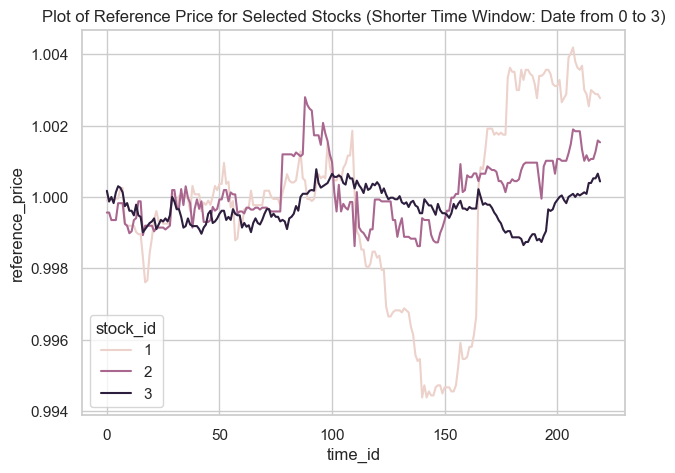

C:\Users\DawnE\AppData\Local\Temp\ipykernel_22252\3231021192.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


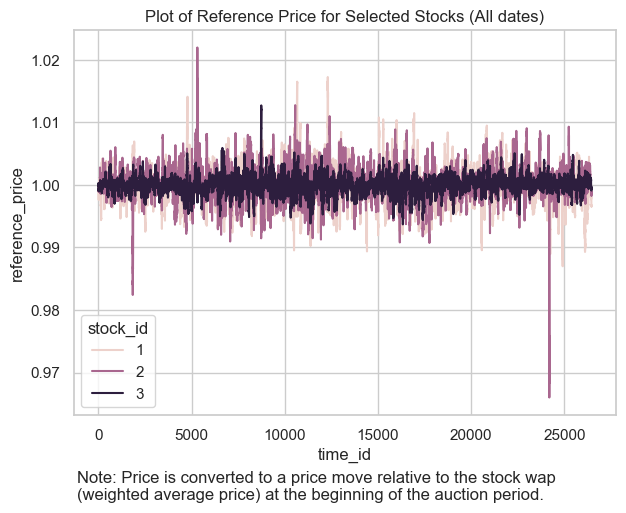

In [146]:
# reference_price: continuous, close to 1
# Check missing: only for 4 stocks in a single date
print('reference_price missing count:', data['reference_price'].isnull().sum())
print(data[data['reference_price'].isnull()].groupby(['stock_id'])['date_id'].value_counts())

print(description['reference_price'])

txt = """Note: Price is converted to a price move relative to the stock wap 
(weighted average price) at the beginning of the auction period."""

# Shorter time window
seclist = [1, 2, 3]
df_stocks = data[data.stock_id.isin(seclist)&(data.date_id<=3)]
fig = plt.figure(figsize=(7, 5))
sns.set_style("whitegrid")
ax = sns.lineplot(data = df_stocks, x = df_stocks['time_id'], y = 'reference_price', hue = 'stock_id');
labels = [item.get_text() for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
ax.legend(loc='lower left', title='stock_id')
plt.xlabel("time_id")
plt.ylabel("reference_price")
plt.title("Plot of Reference Price for Selected Stocks (Shorter Time Window: Date from 0 to 3)")
plt.show()

# All time span
df_stocks = data[data.stock_id.isin(seclist)]
fig = plt.figure(figsize=(7, 5))
sns.set_style("whitegrid")
ax = sns.lineplot(data = df_stocks, x = df_stocks['time_id'], y = 'reference_price', hue = 'stock_id');
labels = [item.get_text() for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
ax.legend(loc='lower left', title='stock_id')
plt.xlabel("time_id")
plt.ylabel("reference_price")
fig.text(.13,-0.06,txt)
plt.title("Plot of Reference Price for Selected Stocks (All dates)")
plt.show()

### matched_size
- The amount that can be matched at the current reference price (in USD).

matched_size missing count: 220
stock_id  date_id
19        438        55
101       328        55
131       35         55
158       388        55
Name: count, dtype: int64
count      5237760.0000
mean      45100245.2844
std      139841291.2774
min           4316.6100
25%        5279575.1650
50%       12882638.5600
75%       32700130.5800
max     7713682054.0500
Name: matched_size, dtype: float64


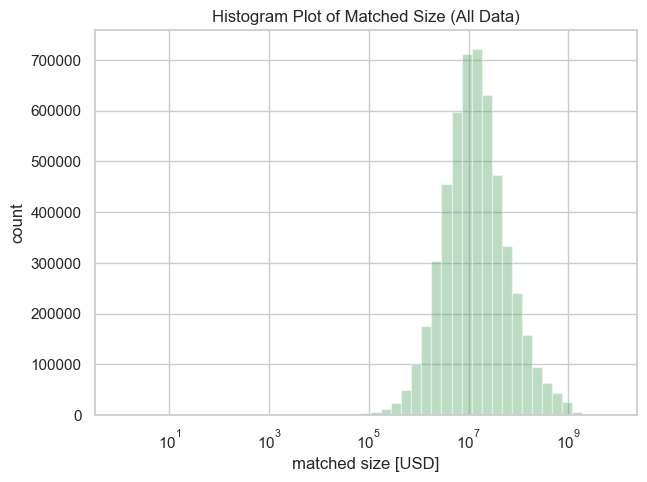

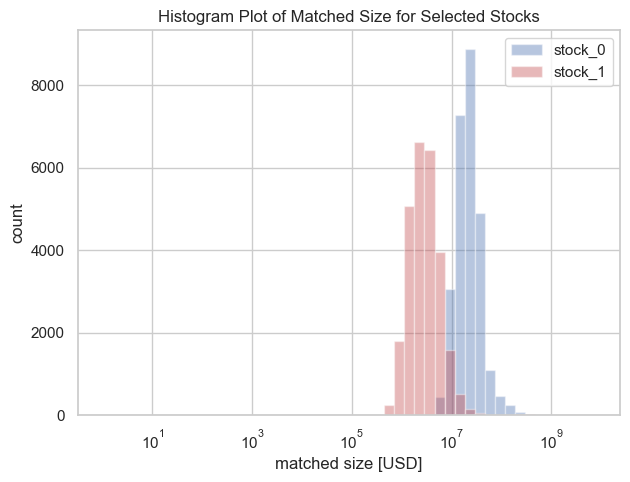

In [150]:
# matched_size: continuous, need log scale
# Check missing: only for 4 stocks in a single date
print('matched_size missing count:', data['matched_size'].isnull().sum())
print(data[data['matched_size'].isnull()].groupby(['stock_id'])['date_id'].value_counts())

print(description['matched_size'])

# Visualization: Distribution for All Data
plt.figure(figsize=(7, 5))
data['matched_size'].plot.hist(color='g', alpha=0.4, align='mid', 
                               bins = np.logspace(np.log10(1),np.log10(np.max(data['matched_size'])),50), log=False)
#plt.semilogy()
plt.semilogx()
plt.xlabel('matched size [USD]')
plt.ylabel('count')
plt.title('Histogram Plot of Matched Size (All Data)')
plt.show()


# Visualization: Distribution for Selected Stocks
plt.figure(figsize=(7, 5))
selected_stock = data[data.stock_id==0]
selected_stock['matched_size'].plot.hist(color='b', alpha=0.4, align='mid', log=False, label='stock_0',
                                         bins = np.logspace(np.log10(1),np.log10(np.max(data['matched_size'])),50))
selected_stock = data[data.stock_id==1]
selected_stock['matched_size'].plot.hist(color='r', alpha=0.4, align='mid', log=False, label='stock_1',
                                         bins = np.logspace(np.log10(1),np.log10(np.max(data['matched_size'])),50))
plt.semilogx()
plt.xlabel('matched size [USD]')
plt.ylabel('count')
plt.title('Histogram Plot of Matched Size for Selected Stocks')
plt.legend()
plt.show()

### imbalance_size
- The amount unmatched at the current reference price (in USD).

imbalance_size missing count: 220
stock_id  date_id
19        438        55
101       328        55
131       35         55
158       388        55
Name: count, dtype: int64
count      5237760.0000
mean       5715293.0987
std       20515906.2972
min              0.0000
25%          84534.1500
50%        1113604.4400
75%        4190951.0025
max     2982027811.6800
Name: imbalance_size, dtype: float64


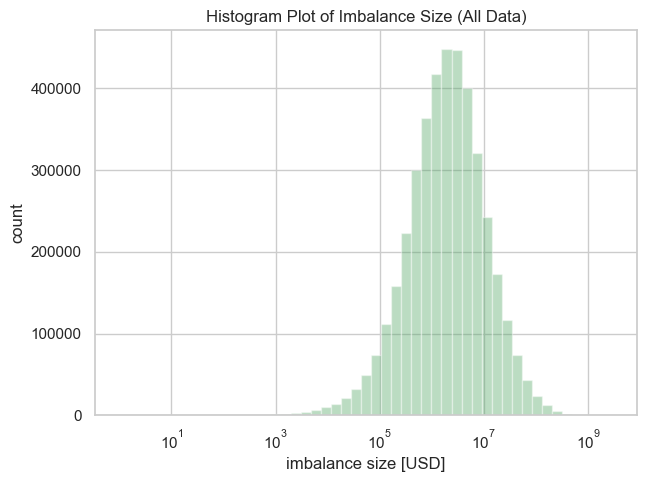

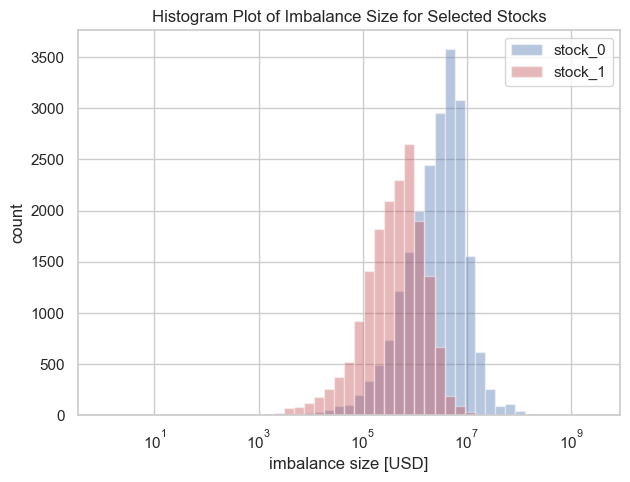

In [151]:
# imbalance_size: continuous, need log scale
# Check missing: only for 4 stocks in a single date
print('imbalance_size missing count:', data['imbalance_size'].isnull().sum())
print(data[data['imbalance_size'].isnull()].groupby(['stock_id'])['date_id'].value_counts())

print(description['imbalance_size'])

# Visualization: Distribution for All Data
plt.figure(figsize=(7, 5))
data['imbalance_size'].plot.hist(color='g', alpha=0.4, align='mid', 
                                 bins = np.logspace(np.log10(1),np.log10(np.max(data['imbalance_size'])),50), log=False)
#plt.semilogy()
plt.semilogx()
plt.xlabel('imbalance size [USD]')
plt.ylabel('count')
plt.title('Histogram Plot of Imbalance Size (All Data)')
plt.show()


# Visualization: Distribution for Selected Stocks
plt.figure(figsize=(7, 5))
selected_stock = data[data.stock_id==0]
selected_stock['imbalance_size'].plot.hist(color='b', alpha=0.4, align='mid', log=False, label='stock_0',
                                           bins = np.logspace(np.log10(1),np.log10(np.max(data['imbalance_size'])),50))
selected_stock = data[data.stock_id==1]
selected_stock['imbalance_size'].plot.hist(color='r', alpha=0.4, align='mid', log=False, label='stock_1',
                                           bins = np.logspace(np.log10(1),np.log10(np.max(data['imbalance_size'])),50))
plt.semilogx()
plt.xlabel('imbalance size [USD]')
plt.ylabel('count')
plt.title('Histogram Plot of Imbalance Size for Selected Stocks')
plt.legend()
plt.show()

### imbalance_buy_sell_flag
- An indicator reflecting the direction of auction imbalance.

1. buy-side imbalance; 1
2. sell-side imbalance; -1
3. no imbalance; 0

imbalance_buy_sell_flag missing count: 0
Series([], Name: count, dtype: int64)
count   5237980.0000
mean         -0.0119
std           0.8853
min          -1.0000
25%          -1.0000
50%           0.0000
75%           1.0000
max           1.0000
Name: imbalance_buy_sell_flag, dtype: float64


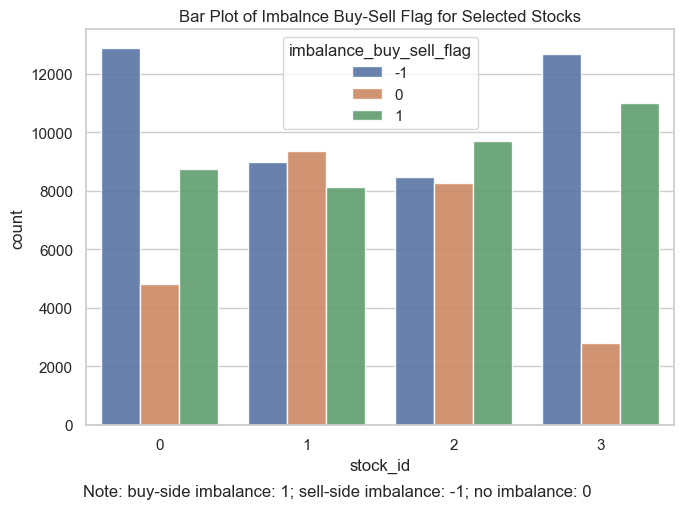

In [130]:
# imbalance_buy_sell_flag: categorical, time variation for single stock
# Check missing: No missing
print('imbalance_buy_sell_flag missing count:', data['imbalance_buy_sell_flag'].isnull().sum())
print(data[data['imbalance_buy_sell_flag'].isnull()].groupby(['stock_id'])['date_id'].value_counts())

print(description['imbalance_buy_sell_flag'])

# Visualization: selected stock
selected_stock_ids = [0,1,2,3]
txt = "Note: buy-side imbalance: 1; sell-side imbalance: -1; no imbalance: 0"
fig = plt.figure(figsize=(7, 5))
sns.set_style("whitegrid")
sns.countplot(data[data.stock_id.isin(selected_stock_ids)], x="stock_id", hue="imbalance_buy_sell_flag", alpha=0.9)
plt.xlabel('stock_id')
plt.ylabel('count')
fig.text(.13,-0.01,txt)
plt.title('Bar Plot of Imbalnce Buy-Sell Flag for Selected Stocks')
plt.tight_layout()
plt.show()

## Auction & Non-acution Book

*far_price* 
- The crossing price that will maximize the number of shares matched based on auction interest only. This calculation excludes continuous market orders.
- This is the price where the most shares can be traded, but it's only considering orders that come from the auction. Any regular, ongoing market orders are ignored for this price.


*near_price* 
- The crossing price that will maximize the number of shares matched based on auction and continuous market orders.
- This price also aims to trade the most shares possible. However, unlike the far_price, it considers both auction orders and the regular orders from the continuous market.

Note: Price is converted to a price move relative to the stock wap (weighted average price) at the beginning of the auction period.

far_price missing pct: 0.5525683565038431
count   2343638.0000
mean          1.0017
std           0.7215
min           0.0001
25%           0.9963
50%           0.9999
75%           1.0033
max         437.9531
Name: far_price, dtype: float64


<Figure size 700x500 with 0 Axes>

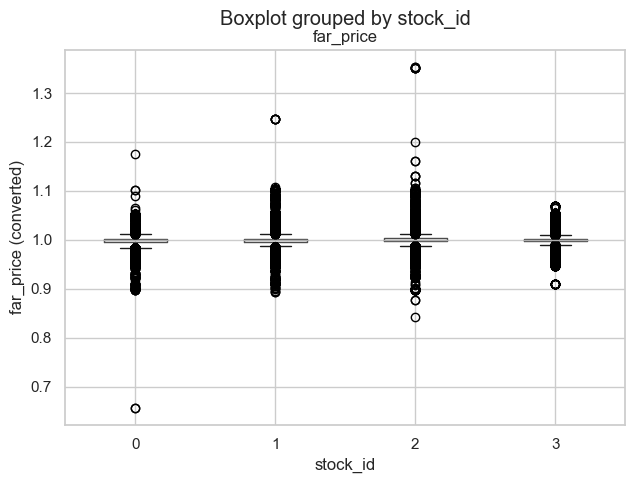

In [170]:
# far_price: continuous, larger range
# Check missing: large amount of missing values
print('far_price missing pct:', data['far_price'].isnull().mean())
print(description['far_price'])

# Visualization: Selected Stock vs far_price
selected_stock_ids = range(4)
plt.figure(figsize=(7, 5))
data[data.stock_id.isin(selected_stock_ids)][['stock_id','far_price']].boxplot(by='stock_id',figsize=(7,5))
plt.xlabel('stock_id')
plt.ylabel('far_price (converted)')
plt.show()

near_price missing pct: 0.5454736367836456
count   2380800.0000
mean          0.9997
std           0.0122
min           0.7870
25%           0.9971
50%           0.9999
75%           1.0026
max           1.3097
Name: near_price, dtype: float64


<Figure size 700x500 with 0 Axes>

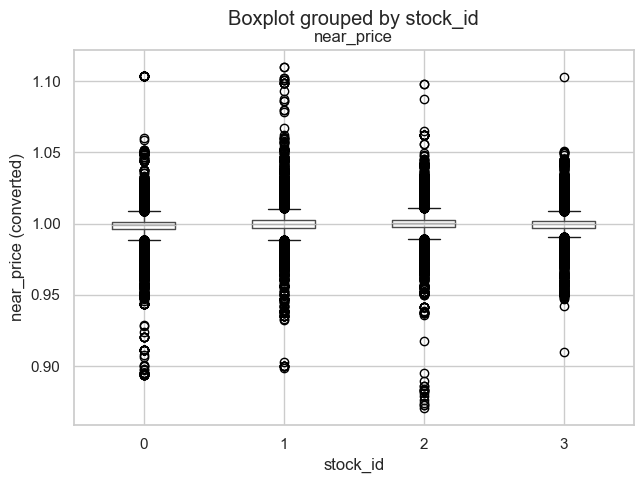

In [166]:
# far_price: continuous, close to 1
# Check missing: large amount of missing values
print('near_price missing pct:', data['near_price'].isnull().mean())
print(description['near_price'])

selected_stock_ids = range(4)
plt.figure(figsize=(7, 5))
data[data.stock_id.isin(selected_stock_ids)][['stock_id','near_price']].boxplot(by='stock_id',figsize=(7,5))
plt.xlabel('stock_id')
plt.ylabel('near_price (converted)')
plt.show()

## Non-acution book / Continuous Order Book

*bid /ask_price* 
- Price of the most competitive buy/sell level in the non-auction book.
- Bid price always <= ask price (can be used to generate features) 


*bid /ask_size* 
- The dollar notional amount on the most competitive buy/sell level in the non-auction book.

​
*wap* 
- The weighted average price in the non-auction book (order book). 
  $$
  \frac{BidPrice * AskSize + AskPrice * BidSize}{BidSize + AskSize}
  $$

Note: Price is converted to a price move relative to the stock wap (weighted average price) at the beginning of the auction period

In [174]:
# bid_price
print('bid_price missing count:', data['bid_price'].isnull().sum())
print(data[data['bid_price'].isnull()].groupby(['stock_id'])['date_id'].value_counts())

# ask_price
print('ask_price missing count:', data['ask_price'].isnull().sum())
print(data[data['ask_price'].isnull()].groupby(['stock_id'])['date_id'].value_counts())

# wap
print('wap missing count:', data['wap'].isnull().sum())
print(data[data['wap'].isnull()].groupby(['stock_id'])['date_id'].value_counts())

bid_price missing count: 220
stock_id  date_id
19        438        55
101       328        55
131       35         55
158       388        55
Name: count, dtype: int64
ask_price missing count: 220
stock_id  date_id
19        438        55
101       328        55
131       35         55
158       388        55
Name: count, dtype: int64
wap missing count: 220
stock_id  date_id
19        438        55
101       328        55
131       35         55
158       388        55
Name: count, dtype: int64


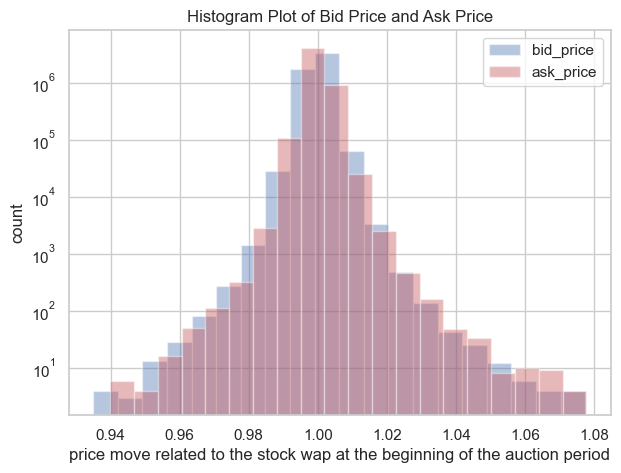

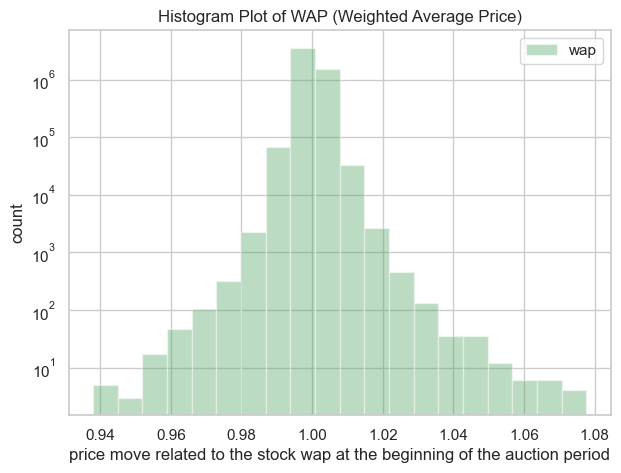

In [175]:
# Visualization: Distribution for bid_price, ask_price, wap
plt.figure(figsize=(7, 5))
data['bid_price'].plot.hist(color='b', alpha=0.4, bins=20, align='mid', log=True, label='bid_price')
data['ask_price'].plot.hist(color='r', alpha=0.4, bins=20, align='mid', log=True, label='ask_price')
plt.semilogy()
plt.xlabel('price move related to the stock wap at the beginning of the auction period')
plt.ylabel('count')
plt.title('Histogram Plot of Bid Price and Ask Price')
plt.legend()
plt.show()

plt.figure(figsize=(7, 5))
data['wap'].plot.hist(color='g', alpha=0.4, bins=20, align='mid', log=True, label='wap')
plt.semilogy()
plt.xlabel('price move related to the stock wap at the beginning of the auction period')
plt.ylabel('count')
plt.title('Histogram Plot of WAP (Weighted Average Price)')
plt.legend()
plt.show()

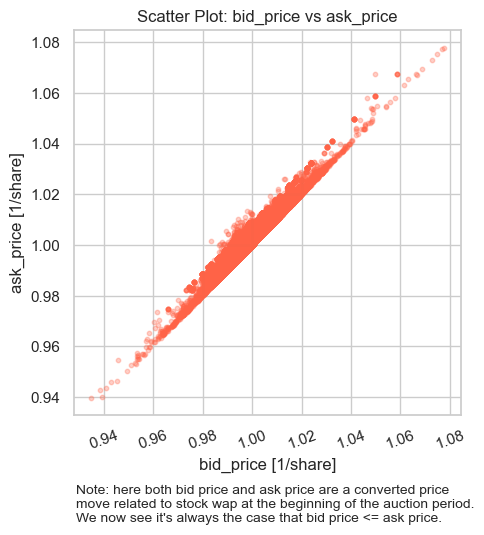

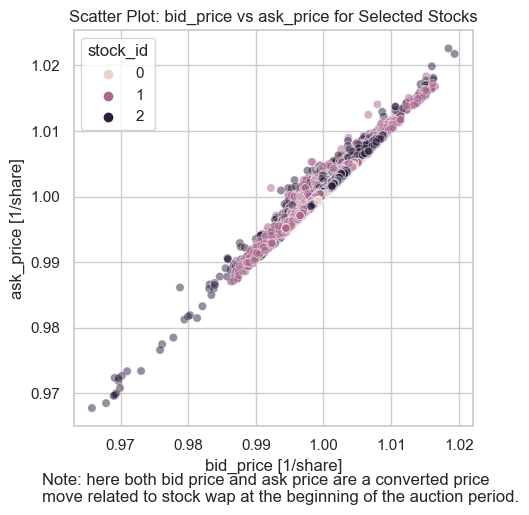

In [209]:
# Visualzation: Scatter Plot of bid_price, ask_price

data.plot.scatter('bid_price', 'ask_price', figsize=(5,5),
                  color='tomato', alpha=0.3, s=10)
txt = """Note: here both bid price and ask price are a converted price
move related to stock wap at the beginning of the auction period.
We now see it's always the case that bid price <= ask price."""

plt.xticks(rotation=20)
plt.xlabel('bid_price [1/share]')
plt.ylabel('ask_price [1/share]')
plt.title('Scatter Plot: bid_price vs ask_price')
plt.figtext(0.13, -0.1, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.show()

# Visualization: Scatter Plot of bid_price, ask_price for selected stock
selected_stock_ids = [0, 1, 2]
txt = """Note: here both bid price and ask price are a converted price
move related to stock wap at the beginning of the auction period."""
fig = plt.figure(figsize=(5, 5))
sns.set_style("whitegrid")
sns.scatterplot(data[data.stock_id.isin(selected_stock_ids)], x="bid_price", y="ask_price", 
                hue="stock_id", alpha=0.5)
plt.xlabel('bid_price [1/share]')
plt.ylabel('ask_price [1/share]')
fig.text(.1,-0.02,txt)
plt.title('Scatter Plot: bid_price vs ask_price for Selected Stocks')
plt.tight_layout()
plt.show()

C:\Users\DawnE\AppData\Local\Temp\ipykernel_22252\3430699313.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


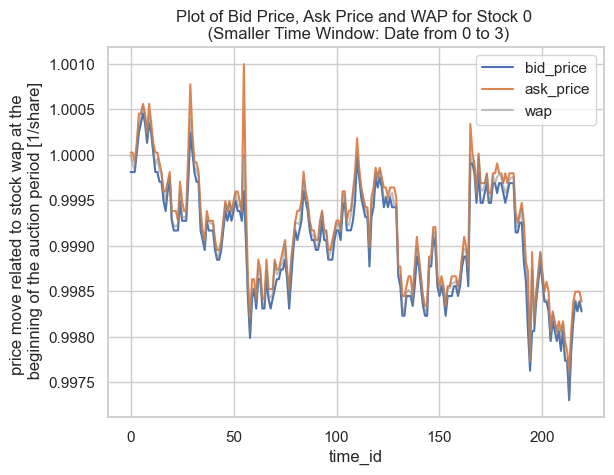

In [199]:
# Wap is always in between
df_stocks = data[(data.stock_id==0)&(data.date_id<=3)]
sns.set_style("whitegrid")
ax = sns.lineplot(data = df_stocks, x = df_stocks['time_id'], y = 'bid_price', alpha=1, label='bid_price', dashes=True)
ax = sns.lineplot(data = df_stocks, x = df_stocks['time_id'], y = 'ask_price', alpha=1, label='ask_price')
ax = sns.lineplot(data = df_stocks, x = df_stocks['time_id'], y = 'wap', label='wap', color='grey', alpha=0.5)
labels = [item.get_text() for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
plt.xlabel("time_id")
plt.ylabel("price move related to stock wap at the \n beginning of the auction period [1/share]")
plt.title("Plot of Bid Price, Ask Price and WAP for Stock 0 \n (Smaller Time Window: Date from 0 to 3)")
plt.show()

### Bid Size and Ask Size

bid_size missing count: 0


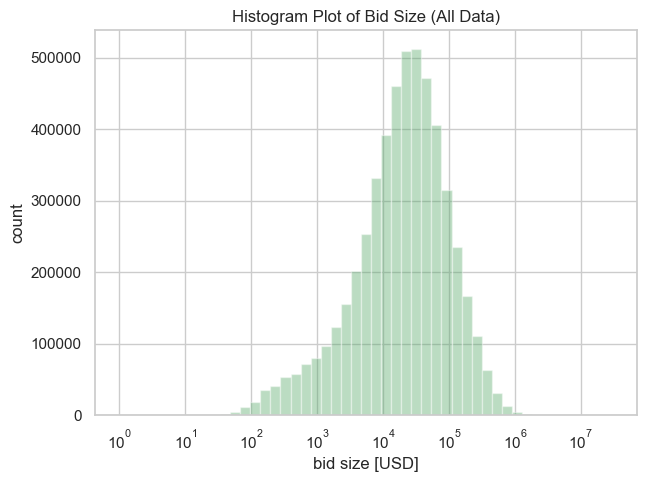

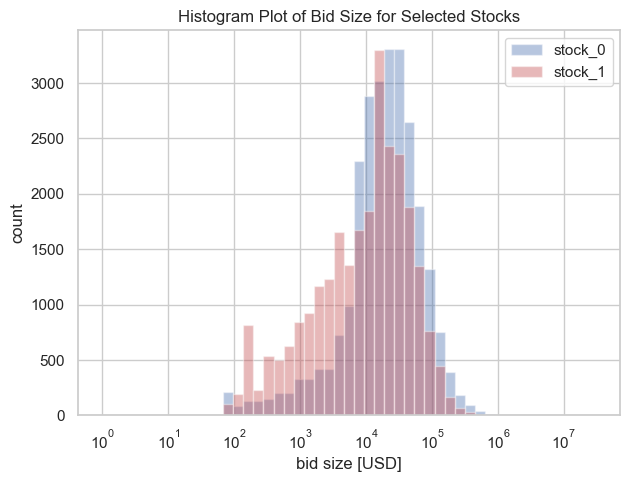

In [204]:
# No missing for bid_size and ask_size
# bid_size
print('bid_size missing count:', data['bid_size'].isnull().sum())

# Visualization: Distribution for All Data
plt.figure(figsize=(7, 5))
data['bid_size'].plot.hist(color='g', alpha=0.4, align='mid', 
                           bins = np.logspace(np.log10(1),np.log10(np.max(data['bid_size'])),50), log=False)
#plt.semilogy()
plt.semilogx()
plt.xlabel('bid size [USD]')
plt.ylabel('count')
plt.title('Histogram Plot of Bid Size (All Data)')
plt.show()


# Visualization: Distribution for Selected Stocks
plt.figure(figsize=(7, 5))
selected_stock = data[data.stock_id==0]
selected_stock['bid_size'].plot.hist(color='b', alpha=0.4, align='mid', log=False, label='stock_0',
                                     bins = np.logspace(np.log10(1),np.log10(np.max(data['bid_size'])),50))
selected_stock = data[data.stock_id==1]
selected_stock['bid_size'].plot.hist(color='r', alpha=0.4, align='mid', log=False, label='stock_1',
                                     bins = np.logspace(np.log10(1),np.log10(np.max(data['bid_size'])),50))
plt.semilogx()
plt.xlabel('bid size [USD]')
plt.ylabel('count')
plt.title('Histogram Plot of Bid Size for Selected Stocks')
plt.legend()
plt.show()

ask_size missing count: 0


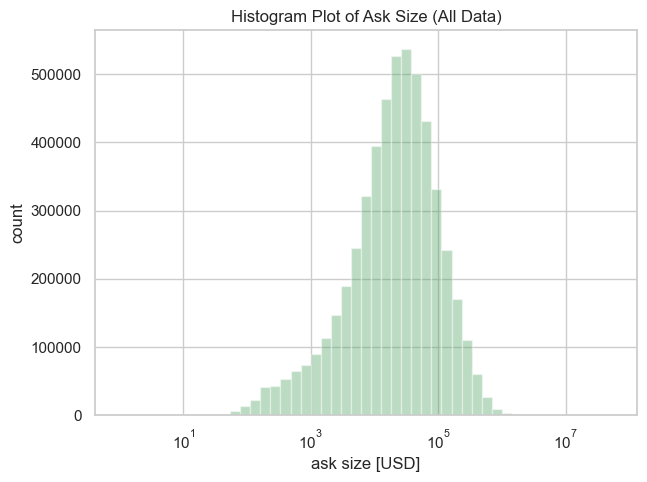

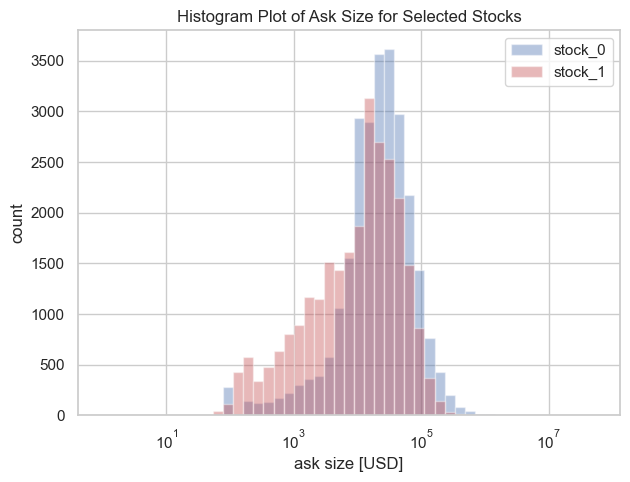

In [205]:
# ask_size: no missing
# Visualization: Distribution for All Data
print('ask_size missing count:', data['ask_size'].isnull().sum())

plt.figure(figsize=(7, 5))
data['ask_size'].plot.hist(color='g', alpha=0.4, align='mid', 
                           bins = np.logspace(np.log10(1),np.log10(np.max(data['ask_size'])),50), log=False)
#plt.semilogy()
plt.semilogx()
plt.xlabel('ask size [USD]')
plt.ylabel('count')
plt.title('Histogram Plot of Ask Size (All Data)')
plt.show()

# Visualization: Distribution for Selected Stocks
plt.figure(figsize=(7, 5))
selected_stock = data[data.stock_id==0]
selected_stock['ask_size'].plot.hist(color='b', alpha=0.4, align='mid', log=False, label='stock_0',
                                     bins = np.logspace(np.log10(1),np.log10(np.max(data['ask_size'])),50))
selected_stock = data[data.stock_id==1]
selected_stock['ask_size'].plot.hist(color='r', alpha=0.4, align='mid', log=False, label='stock_1',
                                     bins = np.logspace(np.log10(1),np.log10(np.max(data['ask_size'])),50))
plt.semilogx()
plt.xlabel('ask size [USD]')
plt.ylabel('count')
plt.title('Histogram Plot of Ask Size for Selected Stocks')
plt.legend()
plt.show()

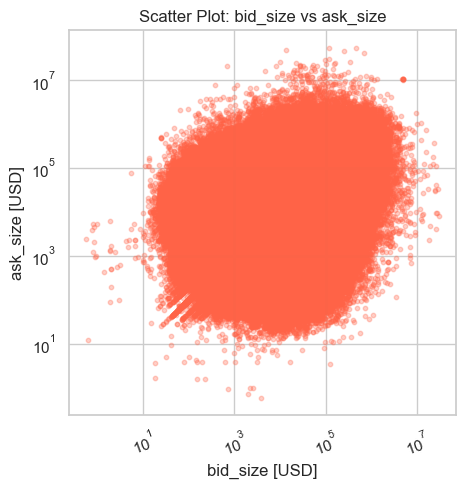

In [207]:
data.plot.scatter('bid_size', 'ask_size', figsize=(5,5),
                  color='tomato', alpha=0.3, s=10)

plt.semilogx()
plt.semilogy()
plt.xticks(rotation=20)
plt.xlabel('bid_size [USD]')
plt.ylabel('ask_size [USD]')
plt.title('Scatter Plot: bid_size vs ask_size')
plt.show()

## Target

- The 60 second future move in the wap of the stock, less the 60 second future move of the synthetic index. Only provided for the train set.
  1. The synthetic index is a custom weighted index of Nasdaq-listed stocks constructed by Optiver for this competition.
  2. The unit of the target is basis points (bps), which is a common unit of measurement in financial markets. A 1 basis point price move is equivalent to a 0.01% price move.
  3. Where t is the time at the current observation, we can define the target:
     $$
     Target = (\frac{StockWAP_{t+60}}{StockWAP_{t}} -  \frac{IndexWAP_{t+60}}{IndexWAP_{t}}) * 10000
	 $$			

### General Info

target missing count: 88
stock_id  date_id
19        438         1
101       328         1
131       35         31
158       388        55
Name: count, dtype: int64


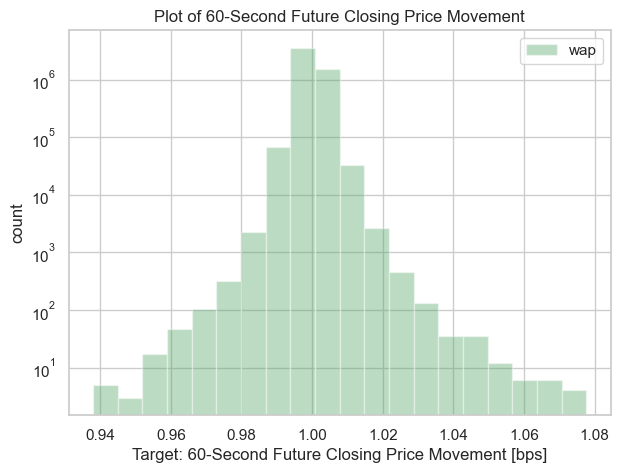

In [210]:
# Check Missing
print('target missing count:', data['target'].isnull().sum())
print(data[data['target'].isnull()].groupby(['stock_id'])['date_id'].value_counts())

# Visualization: Distribution
plt.figure(figsize=(7, 5))
data['wap'].plot.hist(color='g', alpha=0.4, bins=20, align='mid', log=True, label='wap')
plt.semilogy()
plt.xlabel('Target: 60-Second Future Closing Price Movement [bps]')
plt.ylabel('count')
plt.title('Plot of 60-Second Future Closing Price Movement')
plt.legend()
plt.show()

### Individual Stock Analysis

- Different Scales of volatility
- Mean reversion & Volatility
- Extreme Value exists
- Different Time Span

C:\Users\DawnE\AppData\Local\Temp\ipykernel_22252\1753155585.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


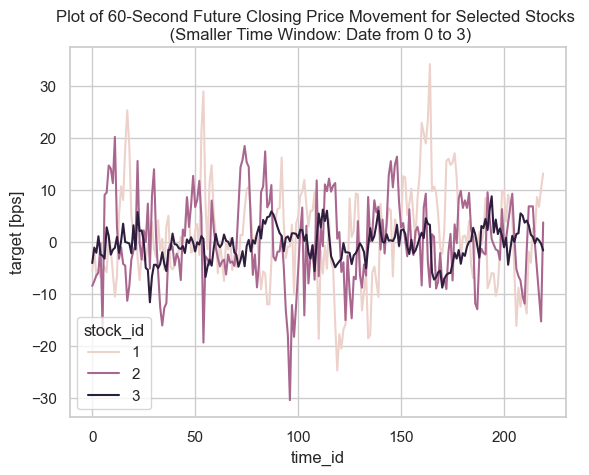

C:\Users\DawnE\AppData\Local\Temp\ipykernel_22252\1753155585.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


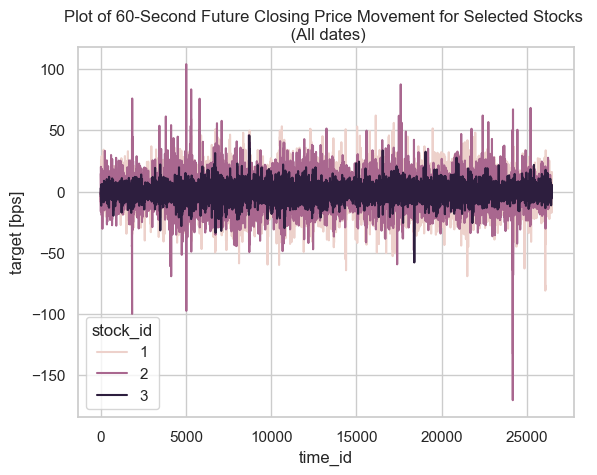

In [211]:
# Shorter time window
seclist = [1, 2, 3]
df_stocks = data[data.stock_id.isin(seclist)&(data.date_id<=3)]
sns.set_style("whitegrid")
ax = sns.lineplot(data = df_stocks, x = df_stocks['time_id'], y = 'target', hue = 'stock_id');
labels = [item.get_text() for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
ax.legend(loc='lower left', title='stock_id')
plt.xlabel("time_id")
plt.ylabel("target [bps]")
plt.title("Plot of 60-Second Future Closing Price Movement for Selected Stocks \n (Smaller Time Window: Date from 0 to 3)")
plt.show()

# All time span
df_stocks = data[data.stock_id.isin(seclist)]
sns.set_style("whitegrid")
ax = sns.lineplot(data = df_stocks, x = df_stocks['time_id'], y = 'target', hue = 'stock_id');
labels = [item.get_text() for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
ax.legend(loc='lower left', title='stock_id')
plt.xlabel("time_id")
plt.ylabel("target [bps]")
plt.title("Plot of 60-Second Future Closing Price Movement for Selected Stocks \n (All dates)")
plt.show()

### Target and Other Features

- Single stock Time Series Plot: e.g., Target and Imbalance Size, Imbalance flage
- Correlation Between Different Stocks (Target)
- box/scatter plot with target / between features (can be grouped by categories)

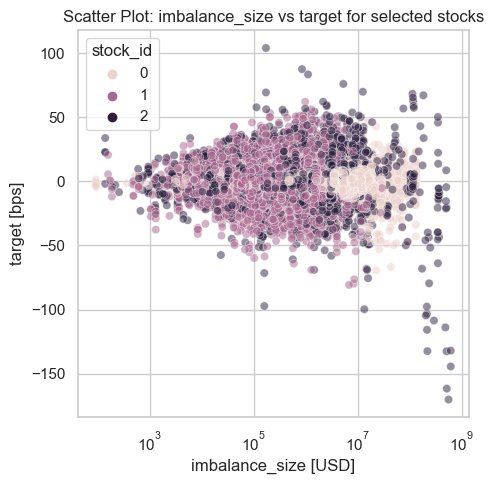

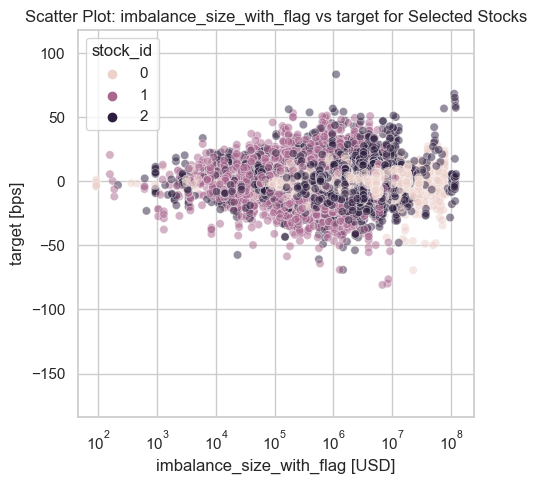

In [237]:
# Visualization: Scatter Plot
selected_stock_ids = [0, 1, 2]

# imbalance_size
fig = plt.figure(figsize=(5, 5))
sns.set_style("whitegrid")
sns.scatterplot(data[data.stock_id.isin(selected_stock_ids)], x="imbalance_size", y="target", 
                hue="stock_id", alpha=0.5)
plt.semilogx()
plt.xlabel('imbalance_size [USD]')
plt.ylabel('target [bps]')
plt.title('Scatter Plot: imbalance_size vs target for selected stocks')
plt.tight_layout()
plt.show()

# imbalance_size_with_flag
data_temp = data.copy()
data_temp['imbalance_size_with_flag'] = data_temp['imbalance_size'].mul(data_temp['imbalance_buy_sell_flag'])
fig = plt.figure(figsize=(5, 5))
sns.set_style("whitegrid")
sns.scatterplot(data_temp[data_temp.stock_id.isin(selected_stock_ids)], x="imbalance_size_with_flag", y="target", 
                hue="stock_id", alpha=0.5)
plt.semilogx()
plt.xlabel('imbalance_size_with_flag [USD]')
plt.ylabel('target [bps]')
plt.title('Scatter Plot: imbalance_size_with_flag vs target for Selected Stocks')
plt.tight_layout()
plt.show()

<Figure size 700x500 with 0 Axes>

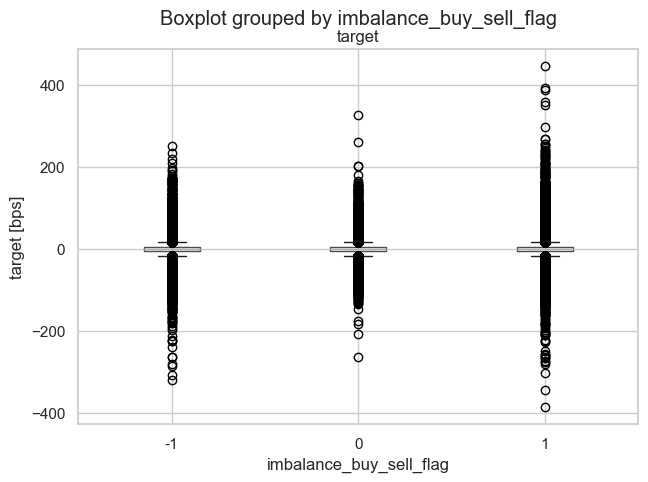

In [238]:
# Visualization: imbalance_buy_sell_flag vs target
selected_stock_ids = range(200)
plt.figure(figsize=(7, 5))
data[data.stock_id.isin(selected_stock_ids)][['imbalance_buy_sell_flag','target']]\
                        .boxplot(by='imbalance_buy_sell_flag',figsize=(7,5))
plt.xlabel('imbalance_buy_sell_flag')
plt.ylabel('target [bps]')
plt.show()

stock_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
time_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-3.0297,-5.5200,-8.3900,-4.0102,-7.3498,6.7794,-2.4998,-1.9598,-5.9700,7.9703,5.3501,2.5594,8.3995,-10.7503,2.3198,1.7202,-8.1700,-3.5900,-11.4399,4.2999,-4.1801,-11.5401,8.9598,2.4402,4.4894,-2.5600,-0.3499,-0.0602,-1.6898,4.6396,4.4096,-1.3900,7.8106,4.4203,-7.7599,0.1895,3.5405,-0.4297,7.8297,-4.6998,-1.3798,4.9603,-10.6698,-3.3402,3.1400,-1.4400,17.1494,10.1900,-7.7599,9.2602,4.2605,6.7103,1.0002,-6.3199,-3.6699,-1.2100,10.4797,6.8295,-1.2797,-3.6001,-1.1098,3.1304,13.7997,2.0301,-22.7302,12.6195,-5.0402,-11.9698,4.0805,NaN,9.6703,-17.8599,-5.5802,-2.5600,3.3605,-6.6799,-1.9801,0.2694,NaN,NaN,-9.6399,16.6905,6.5303,-1.0800,6.3896,-18.8702,30.5200,6.9702,-5.0598,-2.5600,1.5104,2.8396,-42.3503,10.5095,-10.0702,-8.3101,-5.0002,11.2998,-2.4700,13.6805,-5.2297,8.4496,NaN,-1.7601,-5.2100,-1.2797,-8.0401,0.5400,-6.0201,-2.6500,-2.0403,-7.2199,-1.4001,-5.1498,-2.9802,-5.3501,3.3998,2.6202,-7.7403,4.1699,3.5405,-2.0200,9.5296,4.1103,-8.4198,9.0897,-8.5801,5.8305,0.6700,2.1994,-5.3298,5.9104,-17.6603,-2.0200,4.1902,NaN,-2.8402,2.2197,-8.0502,2.7895,-1.2100,-9.0802,-4.1199,-6.8802,-3.0398,7.1502,0.8404,1.5903,11.3106,-1.9902,NaN,-2.5302,-24.0803,NaN,-4.9299,4.3297,NaN,0.8798,-23.6303,-6.4701,-2.5803,-4.0001,-6.1101,-2.5398,4.8995,4.4203,4.9198,0.9704,0.9799,-11.4399,6.0296,-3.4600,-17.7199,-1.4800,19.1998,3.3796,10.5095,-35.9303,8.6999,-11.4697,0.3695,0.2897,14.5996,-4.3797,-4.7398,3.0100,-3.6800,6.3801,19.0198,5.4801,6.3705,11.9400,-11.5299,-6.4898,3.9995,-0.6902,-0.8100,-8.4400,-0.5102,NaN
1,0.3898,-1.6201,-7.4601,-1.0401,-6.7198,7.7105,-4.2802,-8.0103,-0.7802,-0.6402,4.8697,5.4002,4.9901,-4.5300,-1.1700,1.2803,4.4596,-13.8801,1.6201,-2.8801,0.6902,-7.5901,-0.3499,7.8797,8.0395,0.7796,0.4005,9.8205,-8.5598,-6.7300,-0.8398,-14.8797,0.7701,7.1895,3.6395,-6.9898,4.4501,-1.4102,4.7803,-1.3000,2.9695,2.5499,-7.2497,-3.5000,8.3399,1.5104,1.3304,3.7205,-5.2100,-2.5898,6.5804,-3.5602,-7.6598,-5.0700,-1.5199,0.8905,2.2900,-0.2301,-3.7497,-3.6502,7.3195,-2.1601,32.1102,-0.5901,-4.1997,3.2306,-1.5497,-1.0097,2.2995,NaN,-5.0700,-17.8999,-2.8402,-3.4201,-3.1000,-4.6802,-6.0397,2.2995,NaN,NaN,4.2295,31.0600,-2.6298,0.4101,-0.3201,-25.0399,58.0597,-8.5801,-1.7297,1.4997,2.3699,3.1102,-43.0799,-5.5403,-0.0501,-4.3499,-10.1203,9.4795,6.7604,8.0097,-3.0202,-0.3499,NaN,-1.3298,-4.6903,0.4101,-5.1397,-13.4897,-8.8203,-0.3099,0.1800,-6.0898,3.8505,8.9896,9.9802,-5.6398,0.5805,0.6700,-9.6601,4.6504,3.9697,0.5603,16.1695,-2.0999,-19.7601,7.2002,-10.4499,4.2105,1.5104,-2.3103,-3.6401,12.0699,-6.4898,1.1599,3.0100,NaN,1.4400,-10.3599,-5.4097,0.2503,3.1698,-14.4798,-1.1200,-5.4997,-1.7798,-0.8303,1.7595,-5.5897,2.7299,0.1705,NaN,2.9898,-11.1097,NaN,-8.6999,3.2496,NaN,2.9898,11.2200,-12.5498,0.7296,2.9600,-2.8199,-0.5901,-1.8603,-1.4102,0.2503,-0.6098,1.5700,-2.1797,1.2505,1.0800,-31.2400,0.7403,0.0000,5.3000,10.3402,-42.4302,14.0405,-9.5600,-1.9097,1.3196,13.6101,-5.6797,-0.8500,3.7503,-4.8798,6.8498,6.3801,-0.3600,4.2105,2.6000,-15.5997,-1.7500,-9.0301,-1.3202,-3.2598,-4.4101,-1.4198,NaN
2,4.2200,-6.4600,-6.3801,-2.0301,-0.6902,1.0097,2.9302,-12.0699,-4.1199,-3.250

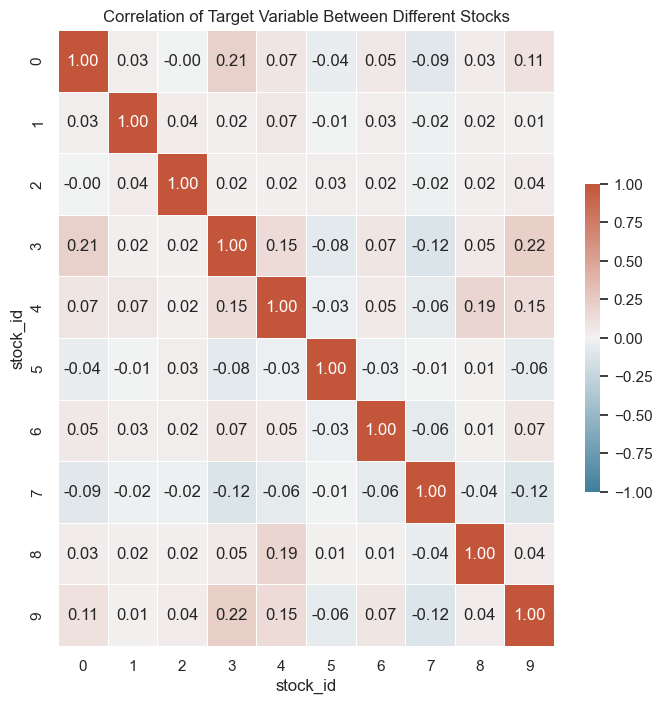

In [233]:
# Correlation Between Different Stocks
data_stocks = data.pivot(index='time_id', columns='stock_id', values='target')
display(data_stocks.head())

selected_stocks = list(range(10))
corr_matrix_stock = data_stocks[selected_stocks].corr()

plt.figure(figsize=(8, 8))
sns.set_theme(style="white")
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_matrix_stock, annot=True, cbar_kws={"shrink": .5}, fmt='.2f',
            linewidths=0.5, vmin=-1, vmax=1, cbar=True, cmap=cmap)
plt.title('Correlation of Target Variable Between Different Stocks')
plt.show()

### Relationship between 2 stocks & Auto Regression for single stock

## Correlationship between features

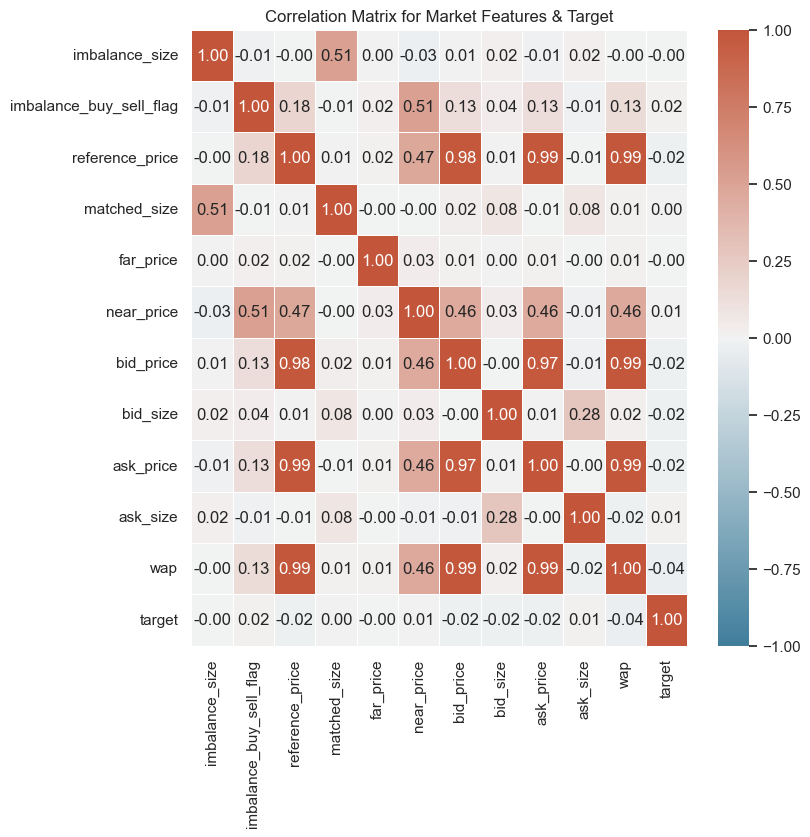

In [232]:
market_features = ['imbalance_size', 'imbalance_buy_sell_flag', 'reference_price', 
                   'matched_size', 'far_price', 'near_price', 'bid_price', 
                   'bid_size', 'ask_price', 'ask_size', 'wap', 'target']

# All data
corr_matrix = data[market_features].corr()
plt.figure(figsize=(8, 8))
sns.heatmap(corr_matrix, annot=True, cmap=cmap, fmt='.2f',
            linewidths=0.5, vmin=-1, vmax=1, cbar=True)
plt.title('Correlation Matrix for Market Features & Target')
plt.show()

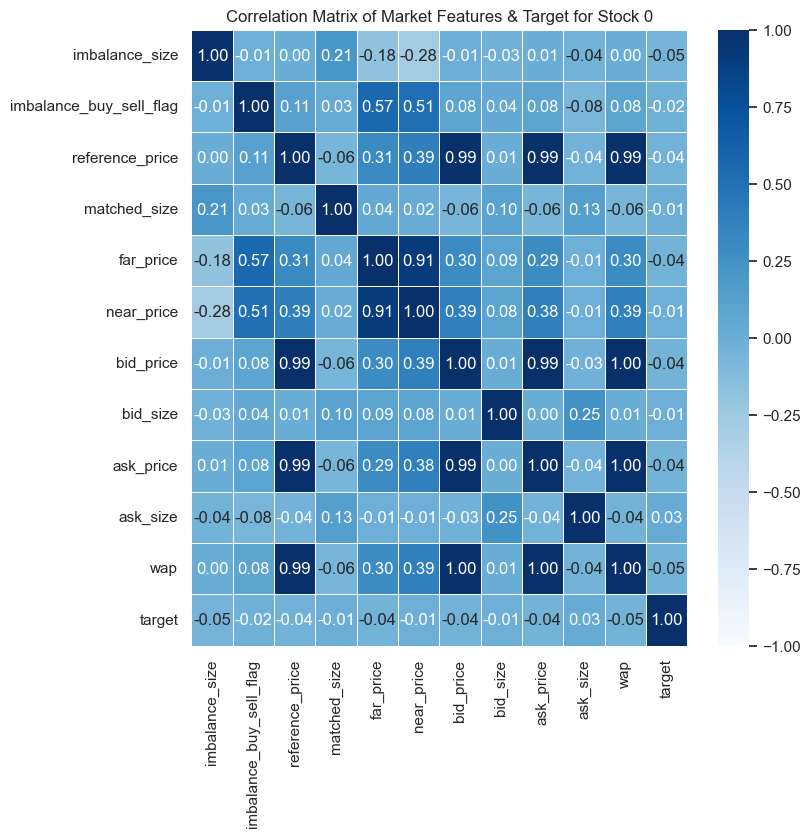

In [220]:
# selected stock
df_stocks = data[data.stock_id==0]
corr_matrix_single = df_stocks[market_features].corr()
plt.figure(figsize=(8, 8))
sns.heatmap(corr_matrix_single, annot=True, cmap='Blues', fmt='.2f',
linewidths=0.5, vmin=-1, vmax=1, cbar=True)
plt.title('Correlation Matrix of Market Features & Target for Stock 0')
plt.show()